In [1]:
import os
import re
import pandas
import pytz
import datetime
from os import listdir
from os.path import isfile, join, exists

import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

sc = SparkContext("local")
sqlContext = SparkSession.builder.getOrCreate()

21/12/03 11:23:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## load data

In [3]:
daily_dataset = sqlContext\
    .read.option('header', True)\
    .csv('/data/smart_city/smart_meters_in_london/daily_dataset/daily_dataset')

In [4]:
daily_dataset.registerTempTable('daily_dataset')
daily_dataset.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- day: string (nullable = true)
 |-- energy_median: string (nullable = true)
 |-- energy_mean: string (nullable = true)
 |-- energy_max: string (nullable = true)
 |-- energy_count: string (nullable = true)
 |-- energy_std: string (nullable = true)
 |-- energy_sum: string (nullable = true)
 |-- energy_min: string (nullable = true)



In [5]:
weather_daily_darksky_spark = sqlContext\
    .read.option('header', True)\
    .csv('/data/smart_city/smart_meters_in_london/weather_daily_darksky.csv')

In [6]:
weather_daily_darksky_spark.printSchema()

root
 |-- temperatureMax: string (nullable = true)
 |-- temperatureMaxTime: string (nullable = true)
 |-- windBearing: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- dewPoint: string (nullable = true)
 |-- temperatureMinTime: string (nullable = true)
 |-- cloudCover: string (nullable = true)
 |-- windSpeed: string (nullable = true)
 |-- pressure: string (nullable = true)
 |-- apparentTemperatureMinTime: string (nullable = true)
 |-- apparentTemperatureHigh: string (nullable = true)
 |-- precipType: string (nullable = true)
 |-- visibility: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- apparentTemperatureHighTime: string (nullable = true)
 |-- apparentTemperatureLow: string (nullable = true)
 |-- apparentTemperatureMax: string (nullable = true)
 |-- uvIndex: string (nullable = true)
 |-- time: string (nullable = true)
 |-- sunsetTime: string (nullable = true)
 |-- temperatureLow: string (nullable = true)
 |-- temperatureMin: string (nullable = 

## reduce data to only a few households

In [7]:
sqlContext.sql(u"""
    select LCLid, count(*), mean(energy_median) as energy_median
    from daily_dataset
    group by LCLid
    """).registerTempTable('median')

In [8]:
sqlContext.sql(u"""
    select *
    from median
    where energy_median > 0.5 and energy_median < 0.6
    """).show(10)

+---------+--------+------------------+
|    LCLid|count(1)|     energy_median|
+---------+--------+------------------+
|MAC002137|     621|0.5709090174718201|
|MAC005302|     745|0.5307436241610739|
|MAC002163|     619|0.5385347333602584|
|MAC003668|     502| 0.570689243725099|
|MAC000116|     808|0.5312518569306929|
|MAC003602|     506|0.5335039521739138|
|MAC000443|     709|0.5821107195345564|
|MAC004102|     652|0.5586150305214728|
|MAC004458|     806|0.5050521093052102|
|MAC002869|     659|0.5168884670713201|
+---------+--------+------------------+
only showing top 10 rows



In [9]:
df = sqlContext.sql(u"""
    select *
    from daily_dataset
    where LCLid in ('MAC004179', 'MAC002761', 'MAC002137')
    """).toPandas()

In [10]:
energy_columns = [
    'energy_median', 
    'energy_mean', 
    'energy_max', 
    'energy_count', 
    'energy_std', 
    'energy_sum', 
    'energy_min',
    ]

for c in energy_columns:
    df[c] = df[c].astype('float')

df['day'] = pandas.to_datetime(df['day'])

In [11]:
df[['day']].head(3)

,day
0,2012-06-18
1,2012-06-19
2,2012-06-20


In [45]:
df['document_id'] = df['LCLid']+df['day'].astype('str')
df['day'] = df['day'].astype('str').apply(lambda x:x[0:10])

<AxesSubplot:xlabel='day'>

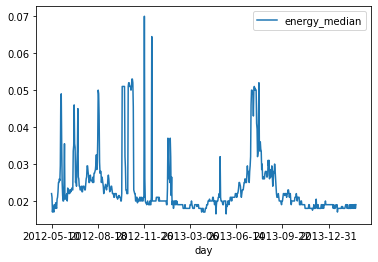

In [46]:
import matplotlib

df1 = pysqldf(u"""
    select day, energy_median
    from df
    where LCLid = 'MAC002761'
    """)

df1 = df1.set_index('day')

df1[['energy_median']].plot()

## prepare the weather data

In [13]:
weather_daily_darksky = weather_daily_darksky_spark.toPandas()

21/12/03 11:24:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
df1 = pysqldf(u"""
    select 
    row_number() over (partition by time order by summary) as rank_id,
    *
    from weather_daily_darksky
    """)

In [15]:
weather_daily_darksky = pysqldf(u"""
    select * from df1 where rank_id = 1
    """).drop(columns = ['rank_id'])

In [16]:
pysqldf(u"""
    select count(*),
    count(distinct time)
    from weather_daily_darksky
    """)

,count(*),count(distinct time)
0,882,882


In [17]:
for c in weather_daily_darksky:    
    try:
        weather_daily_darksky[c] = pandas.to_datetime(weather_daily_darksky[c])
    except:
        try:
            weather_daily_darksky[c] = weather_daily_darksky[c].astype('float')
        except:
            pass

In [18]:
weather_daily_darksky['sunsetHour'] = weather_daily_darksky['sunsetTime'].apply(lambda t:t.hour)
weather_daily_darksky['sunriseHour'] = weather_daily_darksky['sunriseTime'].apply(lambda t:t.hour)
weather_daily_darksky['temperatureHighHour'] = weather_daily_darksky['temperatureHighTime'].apply(lambda t:t.hour)
weather_daily_darksky['temperatureLowHour'] = weather_daily_darksky['temperatureLowTime'].apply(lambda t:t.hour)
weather_daily_darksky['dayTimeHour'] = weather_daily_darksky['sunsetHour'] - weather_daily_darksky['sunriseHour']

In [19]:
weather_daily_darksky['day_weather'] = weather_daily_darksky['time'].dt.date
weather_daily_darksky['day_weather'] = pandas.to_datetime(weather_daily_darksky['day_weather'])

In [20]:
weather_daily_darksky.dtypes

temperatureMax                        float64
temperatureMaxTime             datetime64[ns]
windBearing                           float64
icon                                   object
dewPoint                              float64
temperatureMinTime             datetime64[ns]
cloudCover                            float64
windSpeed                             float64
pressure                              float64
apparentTemperatureMinTime     datetime64[ns]
apparentTemperatureHigh               float64
precipType                             object
visibility                            float64
humidity                              float64
apparentTemperatureHighTime    datetime64[ns]
apparentTemperatureLow                float64
apparentTemperatureMax                float64
uvIndex                               float64
time                           datetime64[ns]
sunsetTime                     datetime64[ns]
temperatureLow                        float64
temperatureMin                    

In [51]:
weather_daily_darksky['day_weather'] = weather_daily_darksky['day_weather'].astype('str').apply(lambda x:x[0:10])

<AxesSubplot:xlabel='day_weather'>

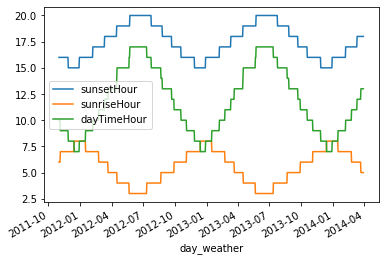

In [50]:
import matplotlib

df1 = weather_daily_darksky

df1 = df1.set_index('day_weather')

df1[['sunsetHour', 'sunriseHour', 'dayTimeHour']].plot()

### load the prediction

In [74]:
prediction_df = sqlContext.read.json('/data/prediction')
prediction_df = prediction_df.toPandas()
prediction_df['document_id'] = prediction_df['LCLid']+prediction_df['day_prediction'].astype('str')

## join the weather to the daily data

In [75]:
dailay_record = pysqldf(u"""
    select 
    p.prediction as energy_median_prediction,
    p.day_prediction as day,
    p.LCLid,
    p.document_id,
    d.energy_median,
    d.energy_mean,
    d.energy_max,
    d.energy_count,
    d.energy_std,
    d.energy_sum,
    d.energy_min,
    w.*
    from prediction_df as p
    left join df as d on d.document_id = p.document_id
    left join weather_daily_darksky as w on w.day_weather = p.day_prediction
    """)

In [76]:
dailay_record.to_json('/data/daily.json',
    lines = True, 
    orient = 'records',
    )